# K-means Clustering - Iris Dataset

K-means is an unsupervised, iterative, convergent method used to split in k clusters a dataset of n elements. First, we randomly locate a set of k initial *centroids* with an associated cluster label, assigning to each point the label of the closest centroid. For each newly defined cluster, the *center of mass* is calculated and the centroid is moved to that position. The process is repeated until convergence is reached and the location of the centroids don't change.

For this purpose, the Iris dataset will be used. It consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). The dataset presents 4 variables: the length and the width of the sepals and petals, in centimeters. In order to visualize our clustering, only 2 of the variables will be chosen.

*Note: Not to be confused with KNN! Some 'genius' decided to define the parameter of the model as k, just like KNN (it seems that 'q','r','p', or any other wasn't good enough)... try to avoid confusion at all cost! one method is supervised; the other isn't.*

### Table of Contents
- [0. Loading the Dataset](#0.-Loading-the-Dataset)
- [1. K-Means Function](#1.-K-Means-Function)
- [2. Finding Optimal k](#2.-Finding-Optimal-k)
- [3.Visualization of the Clusters](#3.-Visualization-of-the-Clusters)

## 0. Loading the Dataset

In [2]:
import numpy   as np
import scipy   as sc
import sklearn as sk
import pandas  as pd
import random

import matplotlib.pyplot as plt

from sklearn.preprocessing  import scale
from sklearn.datasets       import load_iris

In [4]:
# Cargamos los datos
iris=load_iris()
X = iris.data

#Use print iris.DESCR for a detailled description of the dataset (attributes, instances, summary statistics...)
#print(iris.DESCR)

## 1. K-Means Function

We implement our K-means function. Please, read comments for clarifications.

In [4]:
dist = lambda a, b: np.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

def Kmeans(x1, x2, k, max_iters=20,dist=dist):
  
  colors = np.array(["blue", "green", "red", "orange", "yellow", "skyblue", "lightgreen", "salmon"])
  Plot=plt.figure()
  plt.title('a'+str(k))
  
  # Standardizing chosen variables
  x1 = scale(x1, with_mean=True, with_std=True)
  x2 = scale(x2, with_mean=True, with_std=True)
  NewX=np.hstack((x1,x2))
  
  # We randomly initialize centroids, starting each time at the location of one of our points. We avoid repetition.
  index_list = np.arange(x1.shape[0])
  random.shuffle(index_list)
  ic = index_list[:k]
  centr = np.array([x1[ic, 0], x2[ic, 0]]).T 
  # To avoid additional problems (like centroids having one of the dimensions equal), we add a little noise
  centr = centr + np.random.rand(np.shape(centr)[0],np.shape(centr)[1])/10  

  # Visualizing centroids
  for c in range(k):
    plt.plot(centr[c, 0], centr[c, 1], marker="X", markersize=15, c=colors[c])
  # List to save successive positions of centroids
  centr_iter = [centr.T]
    
  for step in range(max_iters):   
    
    # We calculate distances of every points to each centroid - array with shape (kx150)
    distances = np.array([np.array(dist(centr[i], NewX.T)) for i in range(k)])
    # Generate matrix indices: one row per point, where the column index (row number = k) determines the closest centroid
    def only_put_nearest (d):
      z = np.zeros(k, dtype=int)  
      z[np.argmin(d)] = int(1)
      return z
    indices = np.matrix([only_put_nearest(d) for d in distances.T])
    
    # Generates 2 arrays of kx150 for x1 and x2 respectively, where x1/x2 components are separated by index in the k-rows
    x1_sep = np.squeeze(np.array([np.prod([x1, indices[:,i]], axis=0) for i in range(k)]))
    x2_sep = np.squeeze(np.array([np.prod([x2, indices[:,i]], axis=0) for i in range(k)]))
    
    # Now we can calculate the new averaged centroid positions with components in axes x1 and x2. This is the purpose of each step of k-means
    c1_ = np.array([np.sum(x1_sep[i]) / np.count_nonzero(x1_sep[i]) for i in range(k)])
    c2_ = np.array([np.sum(x2_sep[i]) / np.count_nonzero(x2_sep[i]) for i in range(k)])
    
    centr = np.squeeze(np.dstack((c1_,c2_)))    #We stack along the third axis, so it has the original shape. Squeeze needed to avoid unnecesary extra dimensions in array
    
    # Store the new centroid positions to plot trajectory afterwards (but! we will separate x1 and x2 --> transposed!)
    centr_iter.append(centr.T)
    
  #We have centr_iter, an array of arrays containing all the steps taken by the moving centroids
  centr_iter = np.array(centr_iter).T
    
  #Now we plot point in the final state, assigning the same color to all the points of each centroid
  for c in range(k):
    p1, p2 = x1_sep[c], x2_sep[c]
    plt.scatter(p1[p1.nonzero()], p2[p2.nonzero()], color=colors[c], alpha=0.4)
  
  #On the other hand, we plot the final position of the centroid, and the trajectory followed
  for c in range(k):
    plt.plot(centr[c, 0], centr[c, 1], marker="o", markersize=15, c=colors[c])
    for iteration in centr_iter:
      plt.plot(iteration[0], iteration[1], linewidth=1, c='black', linestyle='--')
  
  # Sum of the distances between each point and its centroid
  TotalDistance = np.sum(np.prod([distances.T, indices], axis=0))
  #We prevent the plot from being showed every time we use the function
  plt.close()     
  
  return TotalDistance, Plot

## 2. Finding Optimal k

Now that we have our function implemented, we will try to find the optimal k (number of centroids). In order to do so, in the final state, we measure the distance of each point to its centroid, sum them all and average over different initializations for different k's. 

Defining the optimal k is not trivial though. The distance should, in principle, decrease with increasing k (until we reach k=n with sum of distances equal 0). The optimal  k is found for a value after which the slope flattens (check *elbow method*).

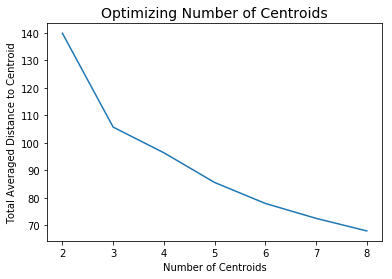

In [12]:
distances=[]
distances_k=[]
K_range=range(2,9)
max_dummy=5

for k in K_range:
  
  for dummy in range(max_dummy):
    TotalDistance, Plot = Kmeans(X[:,0:1],X[:,1:2],k)
    distances_k.append(TotalDistance)
  
  avg_distance_k = np.mean(distances_k)  
  distances.append(avg_distance_k)
  
  distances_k=[]
  avg_distance_k=[]
  
plt.plot(K_range,distances)
plt.title('Optimizing Number of Centroids',fontsize=14)
plt.xlabel('Number of Centroids')
plt.ylabel('Total Averaged Distance to Centroid')
plt.show()

## 3. Visualization of the Clusters

From the figure in last section, it is easy to see that the candidate for optimal k is k=3. And actually, that's the actual number of species: our method works!! Let's plot them and see how our dataset is finally clustered.

*Note: In the following plot, the initial position of the centroid is marked with an X, and the final one with a O.*

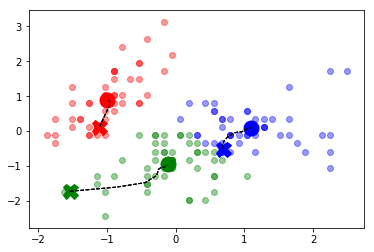

In [9]:
d,p1 = Kmeans(X[:,0:1],X[:,1:2],3)
p1